## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [89]:
import os.path as osp
import numpy as np
import sys
sys.path.append("/home/ozgucbertug/Documents/GitHub")

from latentHeuristics.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latentHeuristics.src.autoencoder import Configuration as Conf
from latentHeuristics.src.point_net_ae import PointNetAutoEncoder

from latentHeuristics.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latentHeuristics.src.tf_utils import reset_tf_graph
from latentHeuristics.src.general_utils import plot_3d_point_cloud

In [46]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define Basic Parameters

In [47]:
top_out_dir = '../out/model/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../ghData/data/' # Top-dir of where point-clouds are stored.

experiment_name = 'custom_multi'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'
class_name = "custom_multi"

Load Point-Clouds

In [106]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

8000 pclouds were loaded. They belong in 1 shape-classes.


Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [49]:
train_params = default_train_params()

In [50]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [51]:
conf = Conf(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

If you ran the above lines, you can reload a saved model like this:

In [52]:
load_pre_trained_ae = True
restore_epoch = 500
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("custom_multi_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("custom_multi_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("custom_multi_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("custom_multi_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("custom_multi_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("custom_multi_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024 Tensor("custom_multi_2/Relu_5:0", shape=(?, 256), dtype=float32)
output size: 256 

decoder_fc_1 FC par

Build AE Model.

In [53]:
if not load_pre_trained_ae:
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)

Train the AE (save output to train_stats.txt) 

In [54]:
if not load_pre_trained_ae:
    buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
    fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
    train_stats = ae.train(all_pc_data, conf, log_file=fout)
    fout.close()

Save all latent vectors

In [127]:
all_latent_vectors = np.zeros((len(all_pc_data.point_clouds),128))

for i in range(len(all_pc_data.point_clouds)):
    pc = all_pc_data.point_clouds[i].reshape((1,2048,3))
    all_latent_vectors[i] = ae.transform(pc)


# vector_dir = top_out_dir+experiment_name+"/"+experiment_name+"_all_latent_vectors.csv"
# np.savetxt(dir, all_latent_vectors, delimiter=',')

label_dir = top_out_dir+experiment_name+"/"+experiment_name+"_all_labels.csv"
np.savetxt(dir,all_pc_data.labels.reshape((1,len(all_pc_data.labels))), delimiter=',', fmt='%s')

Save all labels

In [78]:
feed_pc, feed_model_names, _ = all_pc_data.next_batch(10)
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

((8000, 2048, 3), array(['00000001_asymmetric_0000', '00000001_asymmetric_0001',
       '00000001_asymmetric_0002', ..., '00000001_spiral_1997',
       '00000001_spiral_1998', '00000001_spiral_1999'], dtype=object))


Use any plotting mechanism such as matplotlib to visualize the results.

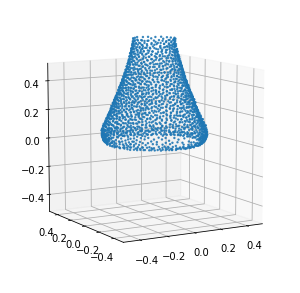

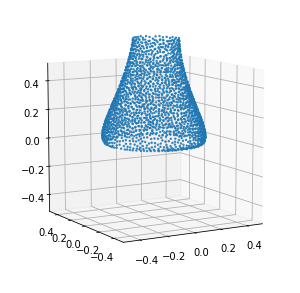

In [80]:
i = 0
plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);

plot_3d_point_cloud(all_pc_data.point_clouds[i][:, 0], 
                    all_pc_data.point_clouds[i][:, 1], 
                    all_pc_data.point_clouds[i][:, 2], in_u_sphere=True);